In [1]:
from time import time
import pandas as pd
import psycopg2
import numpy as np
import gc
import operator

from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF

from scipy.stats.stats import pearsonr

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from PlotWords import plot_word

In [3]:
def selectMatrix(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT m.subject_id,m.word,m.counting,s.isalive "
                      " FROM matrix m LEFT JOIN subjectwords s ON m.subject_id=s.subject_id"
    )
#                      " WHERE m.word in (select word from wordspearson where p1>0.01 order by p1 desc limit 400) "
    cur.execute(select_stament)
    select = []
    for row in cur :
        select.append((row))
    cur.close()
    conn.close()
    return select

In [4]:
def convertMatrix() :
    labels = ['subject_id', 'Word', 'Counting','isAlive']
    df = pd.DataFrame.from_records(selectMatrix(), columns=labels)
    print(len(df))
    table = pd.pivot_table(df,index=["subject_id","isAlive"],columns=["Word"],values=["Counting"],
                       aggfunc={"Counting":[np.sum]},fill_value=0)
    table.columns = [value[2] for value in table.columns.values]
    return table

In [5]:
def generateNMF(patients_train,survived_train,patients_test,survived_test,n_components=30) :
    nmf = NMF(n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5)
    patients_trainnmf = nmf.fit_transform(patients_train)
    H = nmf.components_
    patients_testnmf = nmf.transform(patients_test)
    modelnmf = ajustLogisticRegression(patients_trainnmf,survived_train,patients_testnmf,survived_test)
    return nmf,modelnmf,patients_testnmf

In [6]:
def findpatient(message,table,beats):
    located = table
    groupsize = located.shape[0]
    deads = sum(located.index.labels[1].tolist())
    percent = -1 if groupsize==0 else deads/groupsize
    if groupsize!=0:
        print(message,"groupsize:%d"%groupsize,"deads:%d"%deads,"percent:{0:.2%}".format(percent),beats)

In [7]:
def print_top_words(model, feature_names, n_top_words,topics=[]):
    result = []
    for topic_idx, topic in enumerate(components):
        if(topics==[] or topic_idx in topics):
            features = [{"word":feature_names[i],"p1":str(topic[i])} for i in topic.argsort()[:-n_top_words - 1:-1] if topic[i] > 1]
            result.append({"topic":topic_idx,"features":features})
#        print(topic.argsort())
    return result

In [8]:
from operator import itemgetter
def sortBeats(compoT,table):
    predicts = modelnmf.predict_proba(compoT)[:,1]
    beats = list(table)
    n99,n90,n80,n70,alive = 0,0,0,0,0
    sortedBeats = []
    for i in range(0,len(predicts)):
        sortedBeats.append({'word':beats[i],'predict':predicts[i]})
        if predicts[i]>.99 : n99+=1
        elif predicts[i]>.90 : n90+=1
        elif predicts[i]>.80 : n80+=1
        elif predicts[i]>.70 : n70+=1
        else: alive+=1
    print("over99:%d" %n99,"{0:.2%}".format(n99/5621),"over90:%d" %n90,"{0:.2%}".format(n90/5621),"over80%d:"%n80,
          "{0:.2%}".format(n80/5621),"over70:%d"%n70,"{0:.2%}".format(n70/5621),"under:%d"%alive,
          "{0:.2%}".format(alive/5621))
    return sorted(sortedBeats, key=itemgetter('predict'), reverse=True)

In [9]:
t0=time()
table = convertMatrix()
print("converMatrix done in %0.3fs." % (time() - t0))
print(table.shape)
gc.collect()

134706
converMatrix done in 3.148s.
(658, 5610)


14

In [10]:
table.sort_index(inplace=True,level='isAlive')
survived = table.index.labels[1].tolist()
patients = table.values

In [11]:
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [12]:
n_components=42
nmf,modelnmf,pat_testnmf = generateNMF(patients,survived,patients_test,survived_test,n_components=n_components)

acurracy is 74.24%


In [13]:
components = nmf.components_

In [14]:
components.shape

(42, 5610)

In [15]:
compoT = np.transpose(components)
compoT.shape

(5610, 42)

In [16]:
sortedBeats = sortBeats(compoT,table)
beatKeys = []
for value in sortedBeats:
    beatKeys.append(value['word'])

over99:127 2.26% over90:321 5.71% over801783: 31.72% over70:2863 50.93% under:516 9.18%


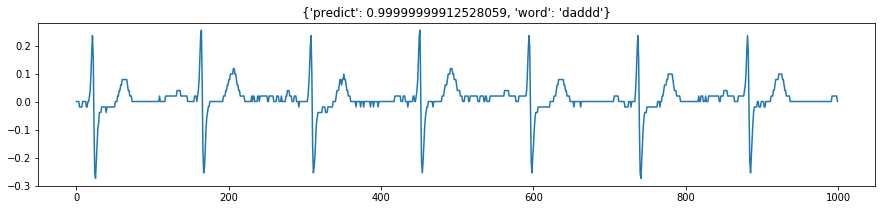

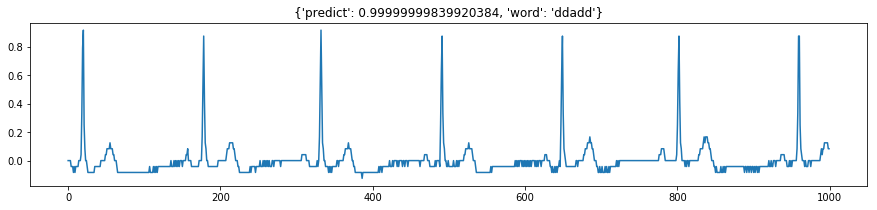

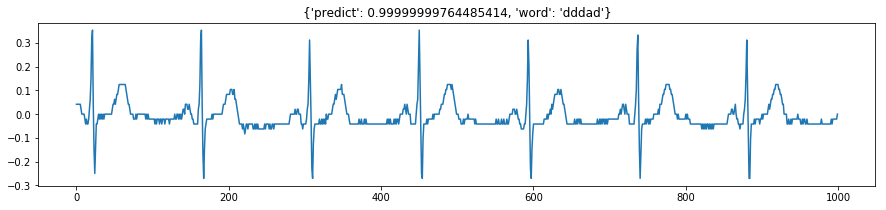

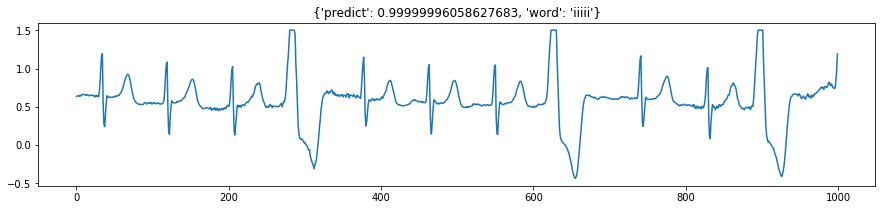

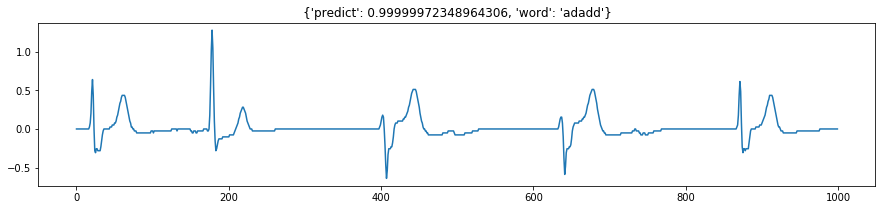

In [17]:
plot_word(sortedBeats[:5])

In [18]:
table.sort_values(by=beatKeys)
survived = table.index.labels[1].tolist()
patients = table.values

In [19]:
nmf,modelnmf,pat_testnmf = generateNMF(patients,survived,patients_test,survived_test,n_components=n_components)

acurracy is 74.24%


In [20]:
components = nmf.components_

In [21]:
n_top_words = 1000
top_words = print_top_words(components, list(table), n_top_words)
for words in top_words:
    print(words['topic'],words['features'][:5])

0 [{'word': 'cacac', 'p1': '11.5081302212'}, {'word': 'acaac', 'p1': '11.1069883283'}, {'word': 'accac', 'p1': '10.741372641'}, {'word': 'acacc', 'p1': '10.5348864749'}, {'word': 'caaca', 'p1': '10.2338461779'}]
1 [{'word': 'cccec', 'p1': '9.62438214188'}, {'word': 'ccecc', 'p1': '9.45772212718'}, {'word': 'cccce', 'p1': '9.0373220571'}, {'word': 'ecccc', 'p1': '8.92132385713'}, {'word': 'ceccc', 'p1': '8.85438248491'}]
2 [{'word': 'adddd', 'p1': '18.4953953255'}, {'word': 'dddda', 'p1': '18.3846569704'}, {'word': 'addad', 'p1': '9.54461459841'}, {'word': 'dadda', 'p1': '9.50770409357'}, {'word': 'ddada', 'p1': '9.22835960046'}]
3 [{'word': 'beeee', 'p1': '11.1578513072'}, {'word': 'eeeeb', 'p1': '10.8264906485'}, {'word': 'bbbbe', 'p1': '8.28700435423'}, {'word': 'ebbbb', 'p1': '7.98591941526'}, {'word': 'bbeee', 'p1': '6.10921450739'}]
4 [{'word': 'bdddd', 'p1': '10.6219716596'}, {'word': 'ddddb', 'p1': '10.4645443083'}, {'word': 'ddbdd', 'p1': '10.4399657762'}, {'word': 'dddbd', 'p1

In [22]:
components.shape

(42, 5610)

In [23]:
i,total=0,0
for component in components:
    i += 1
    total +=sum(component)
    print(sum(component),end=", ")
#    for comp in component:
#        i += 1
#        total +=comp
#        if comp>1:
#            print(comp)
print(i,total,total/i)


231.347605205, 194.103000659, 119.004141986, 111.863741417, 146.336943872, 55.9937763859, 206.444071868, 350.619930564, 214.807346815, 68.8104084588, 398.211395792, 175.678469344, 159.829435946, 158.590516247, 173.254242059, 58.6943275866, 213.816592938, 123.309023106, 179.411578217, 289.31683731, 347.550152872, 731.292760003, 74.1609957792, 162.874986588, 413.226383228, 279.26474194, 134.361170042, 143.477447519, 94.4607675547, 100.633052354, 153.317689052, 194.571284356, 155.813644888, 152.295840932, 128.438583026, 141.861060751, 149.174968531, 266.101400225, 193.479281496, 210.434533494, 73.0168748823, 130.971649543, 42 8060.22265483 191.91006321


In [24]:
patients_trainnmf = nmf.transform(patients_train)

In [25]:
from operator import itemgetter
pearsonList = []
for i in range(n_components):
    patientpear=patients_trainnmf[:,i]
    pearson = pearsonr(patientpear,survived_train)
    if(pearson[0]>0):
        pearsonList.append({'word':i,'p1':pearson[0],'p2':pearson[1]})
sortedList = sorted(pearsonList, key=itemgetter('p1'), reverse=True)
for i in range(10):
    print(sortedList[i])

{'p2': 0.0048097966495162323, 'word': 20, 'p1': 0.12276295131009708}
{'p2': 0.042213894648221249, 'word': 12, 'p1': 0.088609995660381399}
{'p2': 0.14569015916687661, 'word': 25, 'p1': 0.063524766118355447}
{'p2': 0.20237438296398352, 'word': 19, 'p1': 0.055673949904256642}
{'p2': 0.24140728263060268, 'word': 37, 'p1': 0.051167069515557752}
{'p2': 0.28547345388682649, 'word': 40, 'p1': 0.046657195150798407}
{'p2': 0.36064340983988685, 'word': 35, 'p1': 0.039937496843131352}
{'p2': 0.38487371231774581, 'word': 2, 'p1': 0.037964740707751965}
{'p2': 0.53782990080391713, 'word': 8, 'p1': 0.026922324983617709}
{'p2': 0.53979968938260581, 'word': 18, 'p1': 0.026792064796044769}


In [26]:
n_top_words = 10

topics = [sortedList[0]['word'],]
columns = list(table)
top_words = print_top_words(components, columns, 100,topics)
for words in top_words:
    print(words['topic'])
    features = words['features']
#print_top_beats(components, list(table), n_top_words,table,topics)

20


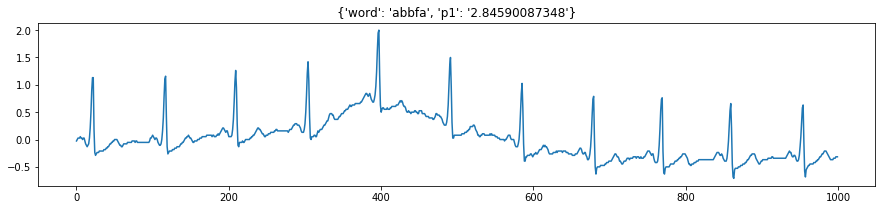

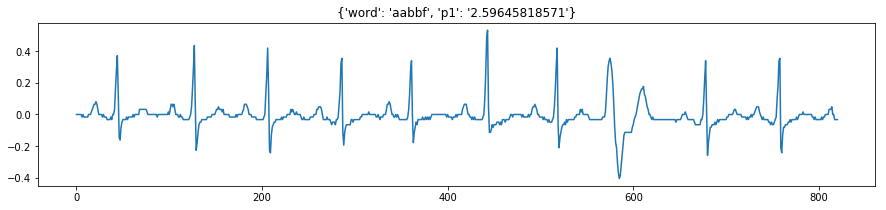

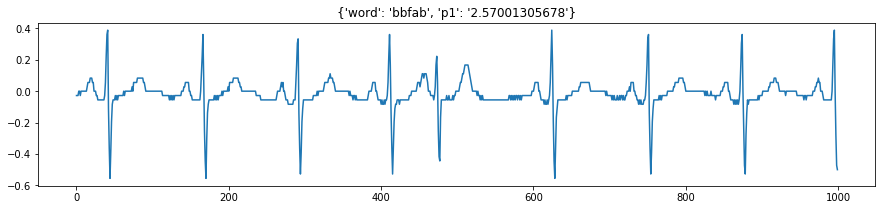

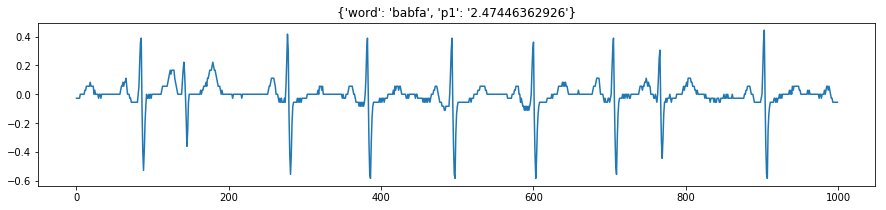

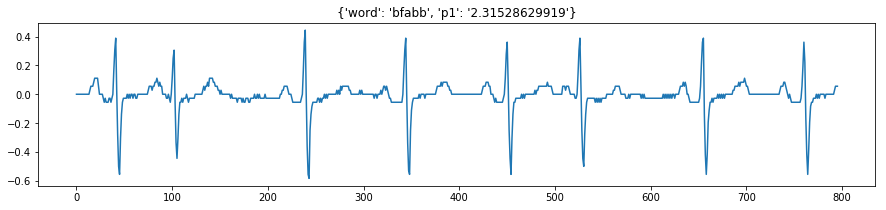

In [27]:
plot_word(features[:5])